# Retrieval Evaluation

In [1]:
# %pip install "haystack-ai>=2.15.0rc1"
# %pip install ragas-haystack
# %pip install nltk
# %pip install openai
# %pip install pandas
# %pip install ragas-haystack
# %pip install "sentence-transformers>=3.0.0"
# %pip install hf_xet
# %pip install "ollama-haystack==2.4.2"
# %pip install tqdm # For Progress Bar
# %pip install einops

In [2]:
import os
from haystack.document_stores.in_memory import InMemoryDocumentStore
import importlib
from datetime import datetime
import pandas as pd
from tqdm import tqdm
tqdm.pandas()
import logging
from models import EmbeddingModelConfig, EmbeddingModelProvider, LLMConfig, LLMProvider
from pipelines.evaluation.base_retrieval_eval_pipeline import get_base_retrieval_eval_pipeline
logging.basicConfig(
    level=logging.WARNING,
    format='%(asctime)s %(levelname)s %(message)s',
    datefmt='%H:%M:%S'
)
logging.getLogger("haystack").setLevel(logging.WARNING)

os.environ["SENTENCE_TRANSFORMERS_HOME"] = "./model-assets/sentence-transformers"
os.environ["HF_HUB_CACHE"] = "./model-assets/hugging-face"


In [ ]:
from config.secret import OPENAI_API_KEY
os.environ["OPENAI_API_KEY"] = OPENAI_API_KEY
os.environ["LLM_CONTEXT_SIZE"] = "8192"

open_embedding_model = "Qwen/Qwen3-Embedding-4B"
closed_embedding_model = "text-embedding-3-large"

open_contextualizer_model = "gemma3:12b"
closed_contextualizer_model = "gpt-4.1-mini"

NUMBER_OF_QUESTIONS_IN_EVAL = 600
TOP_K = 10

In [ ]:
test_configs = [
    {
        "embedding_model": EmbeddingModelConfig(name=open_embedding_model, provider=EmbeddingModelProvider.SENTENCE_TRANSFORMER),
        "reranking_model": None,
        "contextualizer_model": LLMConfig(name=open_contextualizer_model, provider=LLMProvider.OLLAMA),
    },
    {
        "embedding_model": EmbeddingModelConfig(name=open_embedding_model, provider=EmbeddingModelProvider.SENTENCE_TRANSFORMER),
        "reranking_model": None,
        "contextualizer_model": LLMConfig(name=closed_contextualizer_model, provider=LLMProvider.OPEN_AI),
    },
    {
        "embedding_model": EmbeddingModelConfig(name=closed_embedding_model, provider=EmbeddingModelProvider.OPENAI),
        "reranking_model": None,
        "contextualizer_model": LLMConfig(name=open_contextualizer_model, provider=LLMProvider.OLLAMA),
    },
    {
        "embedding_model": EmbeddingModelConfig(name=closed_embedding_model, provider=EmbeddingModelProvider.OPENAI),
        "reranking_model": None,
        "contextualizer_model": LLMConfig(name=closed_contextualizer_model, provider=LLMProvider.OPEN_AI),
    },
]

In [ ]:
now = datetime.now()

def run_retrieval_eval(filename, df):
    import config.prompt
    importlib.reload(config.prompt)

    import re

    match = re.search(r"answers_(.*?)_dataset", filename)
    if match:
        splitting_strategy = match.group(1)
    else:
        splitting_strategy = None

    # 1) Filter out the null‐question rows
    df_nonnull = df[df["question"].notnull()]

    df_shuffled = df_nonnull.sample(n=NUMBER_OF_QUESTIONS_IN_EVAL, random_state=42).reset_index(drop=True)

    for index, row in tqdm(
        df_shuffled.iterrows(),
        total=len(df_shuffled),
        desc="Processing rows",
        unit="row"
    ):
        for test_config in test_configs:
            relevant_documents = row["documents"]
            question = row["question"]

            index_store = InMemoryDocumentStore.load_from_disk(f"data/document_stores/{test_config['embedding_model'].name}/context/{test_config['contextualizer_model'].name}/{splitting_strategy}_indexing_store.json")
            pipeline = get_base_retrieval_eval_pipeline(index_store, test_config["embedding_model"], None)

            request_payload = {
                "retriever": {
                    "top_k": TOP_K,
                },
                "map_evaluator": {
                    "ground_truth_documents": [relevant_documents],
                },
                "mrr_evaluator": {
                    "ground_truth_documents": [relevant_documents],
                },
                "recall_evaluator": {
                    "ground_truth_documents": [relevant_documents],
                }
            }
            if "query_embedder" in pipeline.graph.nodes:
                request_payload["query_embedder"] = {
                    "text": question,
                }
            result = pipeline.run(request_payload)

            map_score = result.get("map_evaluator", {}).get("score", {})
            mrr_score = result.get("mrr_evaluator", {}).get("score", {})
            recall_score = result.get("recall_evaluator", {}).get("score", {})

            df.at[index, f"{test_config['embedding_model'].name}_{test_config['contextualizer_model'].name}_map"] = map_score
            df.at[index, f"{test_config['embedding_model'].name}_{test_config['contextualizer_model'].name}_mrr"] = mrr_score
            df.at[index, f"{test_config['embedding_model'].name}_{test_config['contextualizer_model'].name}_recall"] = recall_score

    save_path = f"results/retrieval/open_closed/{now.strftime('%Y-%m-%d_%H-%M-%S')}/open_closed_result.pkl"
    os.makedirs(os.path.dirname(save_path), exist_ok=True)
    df.to_pickle(save_path)

run_retrieval_eval("data/qa_with_docs_flat/question_answers_docs_word_50_10_dataset_flat.pkl", pd.read_pickle("data/qa_with_docs_flat/question_answers_docs_word_50_10_dataset_flat.pkl"))

Processing rows:   0%|          | 0/600 [00:00<?, ?row/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Processing rows:   0%|          | 1/600 [00:02<21:59,  2.20s/row]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Processing rows:   0%|          | 2/600 [00:04<20:59,  2.11s/row]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Processing rows:   0%|          | 3/600 [00:06<20:57,  2.11s/row]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Processing rows:   1%|          | 4/600 [00:09<24:28,  2.46s/row]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Processing rows:   1%|          | 5/600 [00:11<22:55,  2.31s/row]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Processing rows:   1%|          | 6/600 [00:13<22:10,  2.24s/row]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Processing rows:   1%|          | 7/600 [00:15<21:37,  2.19s/row]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Processing rows:   1%|▏         | 8/600 [00:17<21:16,  2.16s/row]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Processing rows:   2%|▏         | 9/600 [00:19<21:04,  2.14s/row]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Processing rows:   2%|▏         | 10/600 [00:21<20:58,  2.13s/row]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Processing rows:   2%|▏         | 11/600 [00:24<20:54,  2.13s/row]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Processing rows:   2%|▏         | 12/600 [00:26<20:38,  2.11s/row]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Processing rows:   2%|▏         | 13/600 [00:28<20:47,  2.13s/row]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Processing rows:   2%|▏         | 14/600 [00:30<20:35,  2.11s/row]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Processing rows:   2%|▎         | 15/600 [00:32<20:15,  2.08s/row]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Processing rows:   3%|▎         | 16/600 [00:34<19:59,  2.05s/row]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Processing rows:   3%|▎         | 17/600 [00:37<24:09,  2.49s/row]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Processing rows:   3%|▎         | 18/600 [00:39<22:59,  2.37s/row]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Processing rows:   3%|▎         | 19/600 [00:42<23:38,  2.44s/row]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Processing rows:   3%|▎         | 20/600 [00:44<22:42,  2.35s/row]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Processing rows:   4%|▎         | 21/600 [00:46<22:02,  2.28s/row]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Processing rows:   4%|▎         | 22/600 [00:48<21:29,  2.23s/row]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Processing rows:   4%|▍         | 23/600 [00:50<21:03,  2.19s/row]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Processing rows:   4%|▍         | 24/600 [00:52<20:28,  2.13s/row]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Processing rows:   4%|▍         | 25/600 [00:55<20:10,  2.11s/row]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Processing rows:   4%|▍         | 26/600 [00:57<19:50,  2.07s/row]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Processing rows:   4%|▍         | 27/600 [00:59<19:50,  2.08s/row]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Processing rows:   5%|▍         | 28/600 [01:01<19:35,  2.06s/row]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Processing rows:   5%|▍         | 29/600 [01:03<20:03,  2.11s/row]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Processing rows:   5%|▌         | 30/600 [01:05<19:47,  2.08s/row]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Processing rows:   5%|▌         | 31/600 [01:07<19:36,  2.07s/row]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Processing rows:   5%|▌         | 32/600 [01:09<19:36,  2.07s/row]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Processing rows:   6%|▌         | 33/600 [01:12<20:58,  2.22s/row]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Processing rows:   6%|▌         | 34/600 [01:14<20:35,  2.18s/row]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Processing rows:   6%|▌         | 35/600 [01:16<20:06,  2.14s/row]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Processing rows:   6%|▌         | 36/600 [01:18<20:30,  2.18s/row]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Processing rows:   6%|▌         | 37/600 [01:20<20:21,  2.17s/row]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Processing rows:   6%|▋         | 38/600 [01:22<20:30,  2.19s/row]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Processing rows:   6%|▋         | 39/600 [01:24<20:13,  2.16s/row]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Processing rows:   7%|▋         | 40/600 [01:26<19:41,  2.11s/row]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Processing rows:   7%|▋         | 41/600 [01:29<20:43,  2.22s/row]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Processing rows:   7%|▋         | 42/600 [01:31<20:11,  2.17s/row]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Processing rows:   7%|▋         | 43/600 [01:33<20:12,  2.18s/row]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Processing rows:   7%|▋         | 44/600 [01:36<20:52,  2.25s/row]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Processing rows:   8%|▊         | 45/600 [01:38<20:48,  2.25s/row]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Processing rows:   8%|▊         | 46/600 [01:40<20:32,  2.22s/row]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Processing rows:   8%|▊         | 47/600 [01:42<20:25,  2.22s/row]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Processing rows:   8%|▊         | 48/600 [01:44<20:03,  2.18s/row]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Processing rows:   8%|▊         | 49/600 [01:47<21:12,  2.31s/row]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Processing rows:   8%|▊         | 50/600 [01:53<30:52,  3.37s/row]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Processing rows:   8%|▊         | 51/600 [01:55<27:36,  3.02s/row]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Processing rows:   9%|▊         | 52/600 [01:57<25:12,  2.76s/row]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Processing rows:   9%|▉         | 53/600 [01:59<23:29,  2.58s/row]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Processing rows:   9%|▉         | 54/600 [02:01<22:18,  2.45s/row]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Processing rows:   9%|▉         | 55/600 [02:04<21:24,  2.36s/row]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Processing rows:   9%|▉         | 56/600 [02:06<21:07,  2.33s/row]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Processing rows:  10%|▉         | 57/600 [02:09<23:12,  2.56s/row]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Processing rows:  10%|▉         | 58/600 [02:11<22:19,  2.47s/row]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Processing rows:  10%|▉         | 59/600 [02:13<21:05,  2.34s/row]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Processing rows:  10%|█         | 60/600 [02:16<23:29,  2.61s/row]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Processing rows:  10%|█         | 61/600 [02:20<25:11,  2.80s/row]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Processing rows:  10%|█         | 62/600 [02:22<23:18,  2.60s/row]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Processing rows:  10%|█         | 63/600 [02:24<22:31,  2.52s/row]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Processing rows:  11%|█         | 64/600 [02:27<22:39,  2.54s/row]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Processing rows:  11%|█         | 65/600 [02:29<21:28,  2.41s/row]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Processing rows:  11%|█         | 66/600 [02:31<21:50,  2.45s/row]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Processing rows:  11%|█         | 67/600 [02:34<21:09,  2.38s/row]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Processing rows:  11%|█▏        | 68/600 [02:36<20:42,  2.34s/row]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Processing rows:  12%|█▏        | 69/600 [02:38<20:07,  2.27s/row]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

## Analysis

In [8]:
import pandas as pd

df = pd.read_pickle("results/retrieval/open_closed/2025-07-21_14-03-03/open_closed_result_topk-10.pkl")
df

,question,references,groundTruth,source_file,variations_pretty,documents,variant,prev_messages,Qwen/Qwen3-Embedding-4B_gemma3:12b_map,Qwen/Qwen3-Embedding-4B_gemma3:12b_mrr,Qwen/Qwen3-Embedding-4B_gemma3:12b_recall,Qwen/Qwen3-Embedding-4B_gpt-4.1-mini_map,Qwen/Qwen3-Embedding-4B_gpt-4.1-mini_mrr,Qwen/Qwen3-Embedding-4B_gpt-4.1-mini_recall,text-embedding-3-large_gemma3:12b_map,text-embedding-3-large_gemma3:12b_mrr,text-embedding-3-large_gemma3:12b_recall,text-embedding-3-large_gpt-4.1-mini_map,text-embedding-3-large_gpt-4.1-mini_mrr,text-embedding-3-large_gpt-4.1-mini_recall
0,Wie läuft eine äußere Wendung genau ab und was...,[Eine äußere Wendung findet in der Regel in ei...,Eine äußere Wendung findet ambulant in einer K...,Äußere Wendung.md,"""{\""contextual\"": [{\""role\"": \""user\"", \""mess...",[Document(id=6574586c437e0711c9ac7d01e25f91424...,default,[],1.00000,1.000000,1.0,0.500000,0.5,1.0,0.500000,0.50,1.0,0.250000,0.25,1.0
1,Und was passiert dann genau davor?,[Eine äußere Wendung findet in der Regel in ei...,Eine äußere Wendung findet ambulant in einer K...,Äußere Wendung.md,"""{\""contextual\"": [{\""role\"": \""user\"", \""mess...",[Document(id=6574586c437e0711c9ac7d01e25f91424...,contextual,"[Ich habe von der äußeren Wendung gehört, könn...",0.18254,0.142857,1.0,0.500000,0.5,1.0,0.722222,1.00,1.0,0.638889,0.50,1.0
2,Wie genau läuft so ne äußere Wendung ab und wa...,[Eine äußere Wendung findet in der Regel in ei...,Eine äußere Wendung findet ambulant in einer K...,Äußere Wendung.md,"""{\""contextual\"": [{\""role\"": \""user\"", \""mess...",[Document(id=6574586c437e0711c9ac7d01e25f91424...,slang,[],1.00000,1.000000,1.0,0.450000,0.5,1.0,0.833333,1.00,1.0,1.000000,1.00,1.0
3,How is an external version performed exactly a...,[Eine äußere Wendung findet in der Regel in ei...,Eine äußere Wendung findet ambulant in einer K...,Äußere Wendung.md,"""{\""contextual\"": [{\""role\"": \""user\"", \""mess...",[Document(id=6574586c437e0711c9ac7d01e25f91424...,english,[],0.50000,0.500000,1.0,0.642857,1.0,1.0,0.500000,0.50,1.0,0.700000,1.00,1.0
4,äußere Wendung Ablauf Vorbereitung,[Eine äußere Wendung findet in der Regel in ei...,Eine äußere Wendung findet ambulant in einer K...,Äußere Wendung.md,"""{\""contextual\"": [{\""role\"": \""user\"", \""mess...",[Document(id=6574586c437e0711c9ac7d01e25f91424...,keyword,[],0.12500,0.125000,1.0,0.000000,0.0,0.0,0.250000,0.25,1.0,0.000000,0.00,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
605,Risiken Ballonkatheter?,[Die Einlage und das Befüllen der Ballons könn...,Bei der Anwendung eines Ballonkatheters kann d...,Einleitung der Geburt.md,"""{\""contextual\"": [{\""role\"": \""user\"", \""mess...",[Document(id=b92aa18d221df9e8cbef44cd1db9e8a52...,short,[],NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
606,"Ich möchte wissen, welche möglichen Komplikati...",[Die Einlage und das Befüllen der Ballons könn...,Bei der Anwendung eines Ballonkatheters kann d...,Einleitung der Geburt.md,"""{\""contextual\"": [{\""role\"": \""user\"", \""mess...",[Document(id=b92aa18d221df9e8cbef44cd1db9e8a52...,long,[],NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
607,Welche potenziellen Komplikationen und Risiken...,[Die Einlage und das Befüllen der Ballons könn...,Bei der Anwendung eines Ballonkatheters kann d...,Einleitung der Geburt.md,"""{\""contextual\"": [{\""role\"": \""user\"", \""mess...",[Document(id=b92aa18d221df9e8cbef44cd1db9e8a52...,technical,[],NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
608,Welche Risiken gibt es bei der Anwendung eines...,[Die Einlage und das Befüllen der Ballons könn...,Bei der Anwendung eines Ballonkatheters kann d...,Einleitung der Geburt.md,"""{\""contextual\"": [{\""role\"": \""user\"", \""mess...",[Document(id=b92aa18d221df9e8cbef44cd1db9e8a52...,mistake,[],NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


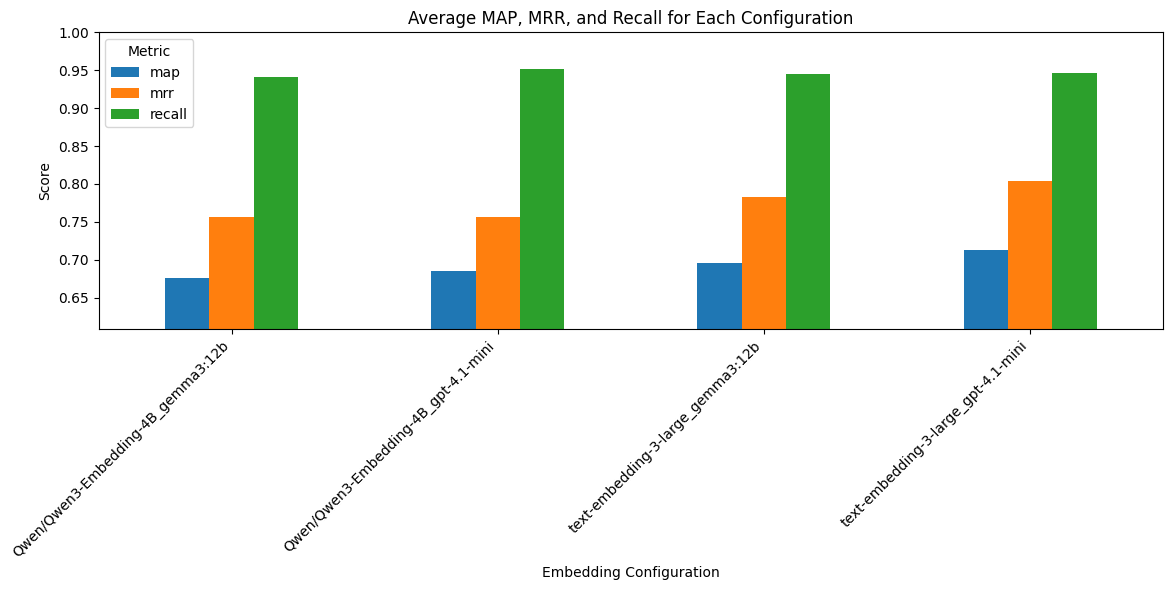

In [9]:
import pandas as pd
import matplotlib.pyplot as plt

# Your DataFrame is assumed to be `df`
metric_prefixes = ['Qwen/Qwen3-Embedding-4B_gemma3:12b',
                   'Qwen/Qwen3-Embedding-4B_gpt-4.1-mini',
                   'text-embedding-3-large_gemma3:12b',
                   'text-embedding-3-large_gpt-4.1-mini']
metrics = ['map', 'mrr', 'recall']

# Build data dictionary
data = {}
for prefix in metric_prefixes:
    values = []
    for metric in metrics:
        col_name = f"{prefix}_{metric}"
        avg_value = df[col_name].mean()
        values.append(avg_value)
    data[prefix] = values

# Create DataFrame for plotting
metrics_df = pd.DataFrame(data, index=metrics)

# Find the minimum and maximum to scale y-axis
y_min = metrics_df.min().min()

# Plotting
ax = metrics_df.T.plot(kind='bar', figsize=(12, 6))
plt.title("Average MAP, MRR, and Recall for Each Configuration")
plt.ylabel("Score")
plt.xlabel("Embedding Configuration")
plt.xticks(rotation=45, ha='right')
plt.ylim(y_min * 0.9, 1.0)  # add some padding
plt.legend(title="Metric")
plt.tight_layout()
plt.show()

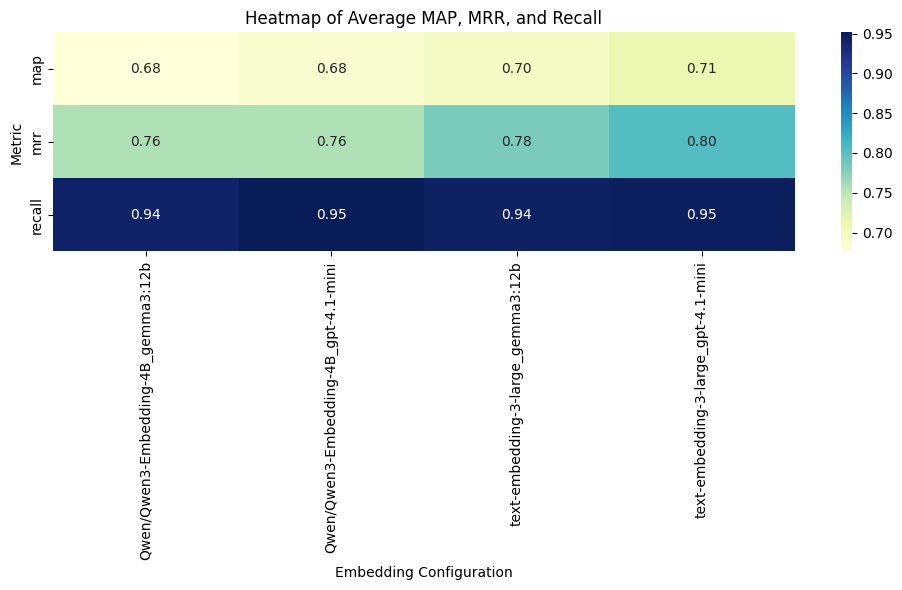

In [10]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

# Assuming `df` is your DataFrame
metric_prefixes = ['Qwen/Qwen3-Embedding-4B_gemma3:12b',
                   'Qwen/Qwen3-Embedding-4B_gpt-4.1-mini',
                   'text-embedding-3-large_gemma3:12b',
                   'text-embedding-3-large_gpt-4.1-mini']
metrics = ['map', 'mrr', 'recall']

# Compute the average value for each metric/config combo
data = {}
for prefix in metric_prefixes:
    values = []
    for metric in metrics:
        col_name = f"{prefix}_{metric}"
        avg_value = df[col_name].mean()
        values.append(avg_value)
    data[prefix] = values

# Convert to DataFrame: rows = metrics, columns = configurations
heatmap_df = pd.DataFrame(data, index=metrics)

# Plot heatmap
plt.figure(figsize=(10, 6))
sns.heatmap(heatmap_df, annot=True, cmap="YlGnBu", fmt=".2f")
plt.title("Heatmap of Average MAP, MRR, and Recall")
plt.xlabel("Embedding Configuration")
plt.ylabel("Metric")
plt.tight_layout()
plt.show()

/tmp/ipykernel_2517031/2177461456.py:68: FutureWarning: 

The `ci` parameter is deprecated. Use `errorbar=None` for the same effect.

  ax = sns.barplot(


TypeError: tuple indices must be integers or slices, not str

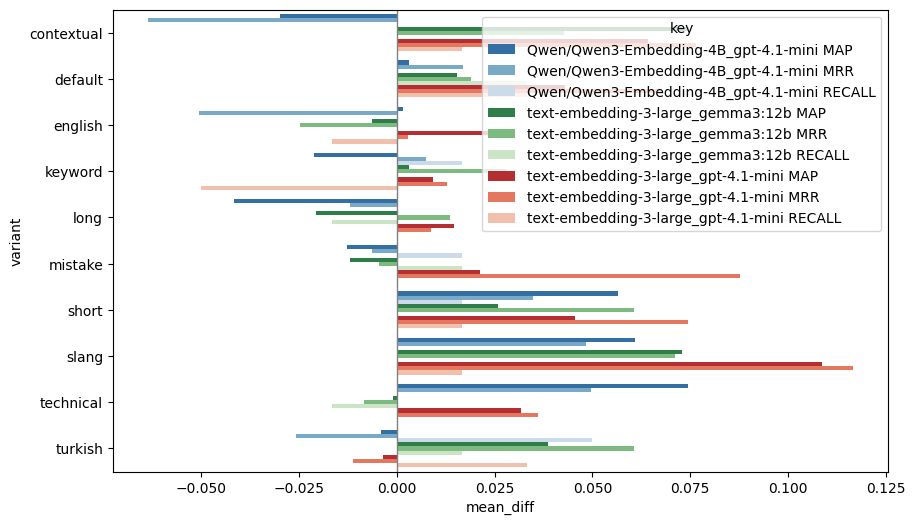

In [12]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
from scipy.stats import ttest_1samp

# ─── 0) assume `df` is loaded with columns:
#      'variant',
#      'Qwen/Qwen3-Embedding-4B_gemma3:12b_map',  …_mrr, …_recall,
#      'Qwen/Qwen3-Embedding-4B_gpt-4.1-mini_map', …,
#      'text-embedding-3-large_gemma3:12b_map', …,
#      'text-embedding-3-large_gpt-4.1-mini_map', …
# ────────────────────────────────────────────────────────────────────────────────

BASE    = 'Qwen/Qwen3-Embedding-4B_gemma3:12b'
CONFIGS = [
    'Qwen/Qwen3-Embedding-4B_gpt-4.1-mini',
    'text-embedding-3-large_gemma3:12b',
    'text-embedding-3-large_gpt-4.1-mini',
]
METRICS = ['map', 'mrr', 'recall']

# 1) compute per-row diffs for each config & metric
for cfg in CONFIGS:
    for m in METRICS:
        df[f'diff_{cfg}_{m}'] = (
            df[f'{cfg}_{m}'].astype(float)
          - df[f'{BASE}_{m}'].astype(float)
        )

# 2) aggregate by variant, metric & config, run t-test
records = []
for variant, grp in df.groupby('variant'):
    for cfg in CONFIGS:
        for m in METRICS:
            col = f'diff_{cfg}_{m}'
            vals = grp[col].dropna().astype(float)
            mean_diff = vals.mean()
            _, p = ttest_1samp(vals, 0)
            records.append({
                'variant':     variant,
                'config':      cfg,
                'metric':      m.upper(),
                'mean_diff':   mean_diff,
                'significant': p < 0.05
            })

summary = pd.DataFrame(records)

# 3) prepare for plotting: combine config+metric into one hue key
summary['key'] = summary['config'] + ' ' + summary['metric']

# 4) build a 3×3 palette: one sequential palette per config
pal = {}
# Blues for CONFIGS[0], Greens for CONFIGS[1], Reds for CONFIGS[2]
seqs = [sns.color_palette("Blues",3)[::-1],
        sns.color_palette("Greens",3)[::-1],
        sns.color_palette("Reds",3)[::-1]]
for cfg, seq in zip(CONFIGS, seqs):
    for col_idx, m in enumerate(['MAP','MRR','RECALL']):
        pal[f"{cfg} {m}"] = seq[col_idx]

hue_order = [f"{cfg} {m}" for cfg in CONFIGS for m in ['MAP','MRR','RECALL']]
variants  = sorted(summary['variant'].unique())

# 5) draw the barplot
plt.figure(figsize=(10, 6))
ax = sns.barplot(
    data=summary,
    y='variant',
    x='mean_diff',
    hue='key',
    hue_order=hue_order,
    palette=pal,
    order=variants,
    ci=None
)

# zero line
ax.axvline(0, color='gray', linewidth=1)

# annotate significance stars
sig_map = {
    (r.variant, r['config'], r['metric']): r.significant
    for r in summary.itertuples()
}
for hue_idx, container in enumerate(ax.containers):
    key = hue_order[hue_idx]            # e.g. "text-embedding-3-large_gemma3:12b RECALL"
    cfg, metr = key.rsplit(' ',1)
    for bar_idx, bar in enumerate(container.patches):
        variant = variants[bar_idx]
        if not sig_map.get((variant, cfg, metr), False):
            continue
        x = bar.get_width()
        y = bar.get_y() + bar.get_height()/2
        dx = 3 if x >= 0 else -3
        ax.annotate(
            "✱",
            xy=(x,y),
            xytext=(dx,0),
            textcoords="offset points",
            ha="left" if x>=0 else "right",
            va="center",
            fontsize=6
        )

ax.set_title("Mean MAP/MRR/Recall Difference vs. Qwen/Qwen3-Embedding-4B_gemma3:12b\n(by Variant)")
ax.set_xlabel("Mean Score Difference")
ax.set_ylabel("Variant")
ax.legend(title="", bbox_to_anchor=(1.02,1), loc="upper left")
plt.tight_layout()
plt.show()